In [11]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm

In [12]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc, 'b', label='E population')
  plt.plot(x, FI_inh, 'r', label='I population')
  plt.legend(loc='lower right')
  plt.xlabel('x (a.u.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='E population')
  ax1.plot(pars['range_t'], rI1, 'r', label='I population')
  ax1.set_ylabel('Activity')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE2, 'b', label='E population')
  ax2.plot(pars['range_t'], rI2, 'r', label='I population')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Activity')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')
  plt.show()


def my_plot_nullcline(pars):
  Exc_null_rE = np.linspace(-0.01, 0.96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rI = np.linspace(-.01, 0.8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
  rE_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.

  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend

  Returns:
    figure of trajectory
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                       'Sample trajectories \nfor different init. conditions')
  my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                     'Sample trajectory for \nlow activity')
  my_plot_trajectory(pars, 'm', [0.6, 0.6],
                     'Sample trajectory for \nhigh activity')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')

  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)

In [4]:
# @title Helper functions


def default_pars(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau_E'] = 1.     # Timescale of the E population [ms]
  pars['a_E'] = 1.2      # Gain of the E population
  pars['theta_E'] = 2.8  # Threshold of the E population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population

  # Connection strength
  pars['wEE'] = 9.   # E to E
  pars['wEI'] = 4.   # I to E
  pars['wIE'] = 13.  # E to I
  pars['wII'] = 11.  # I to I

  # External input
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .1        # Simulation time step [ms]
  pars['rE_init'] = 0.2  # Initial value of E
  pars['rI_init'] = 0.2  # Initial value of I

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivative of the population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  :  Derivative of the population activation function.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE

def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  # Compute the derivative of rE
  drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  # Compute the derivative of rI
  drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  return drEdt, drIdt

def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E population
    drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI

In [8]:
pars = default_pars()

In [9]:
print(pars)

{'tau_E': 1.0, 'a_E': 1.2, 'theta_E': 2.8, 'tau_I': 2.0, 'a_I': 1.0, 'theta_I': 4.0, 'wEE': 9.0, 'wEI': 4.0, 'wIE': 13.0, 'wII': 11.0, 'I_ext_E': 0.0, 'I_ext_I': 0.0, 'T': 50.0, 'dt': 0.1, 'rE_init': 0.2, 'rI_init': 0.2, 'range_t': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 1

/var/folders/xk/gnb4n0td03qbprstn71hlyvc0000gn/T/ipykernel_2444/1483626268.py:91: RuntimeWarning: invalid value encountered in reciprocal
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


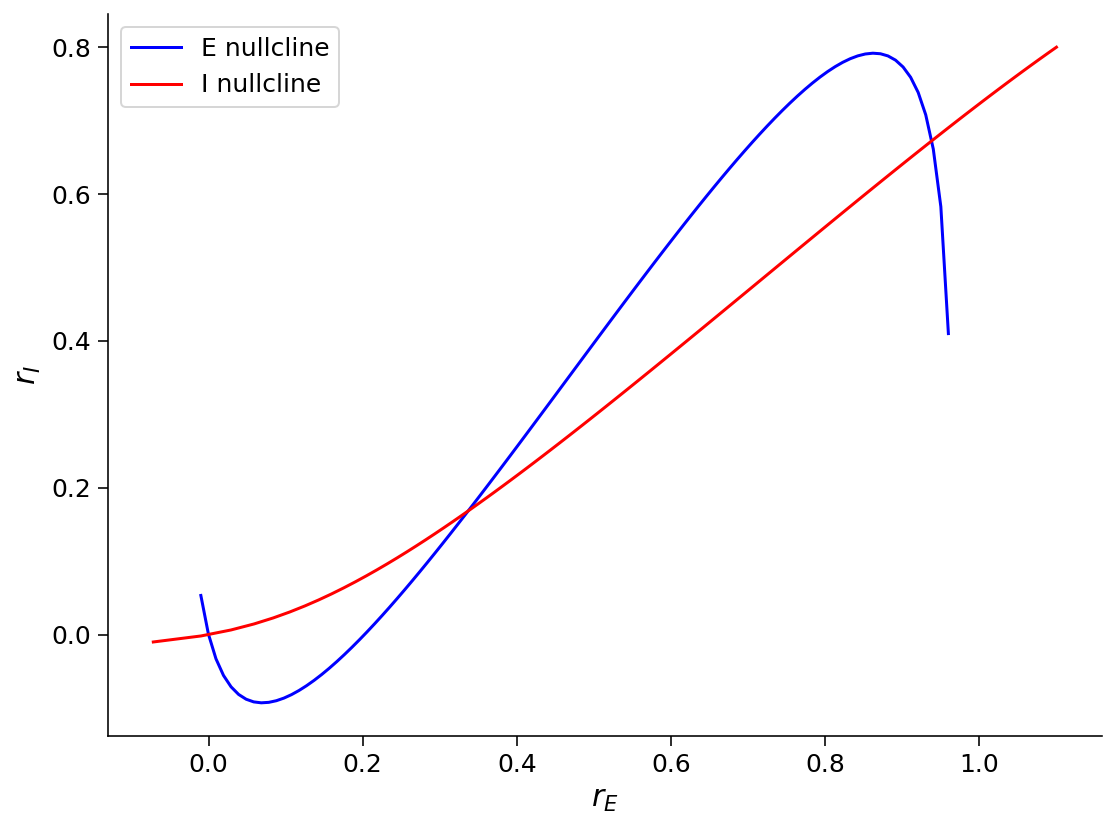

In [10]:
# @markdown Execute to visualize nullclines

# Set parameters
pars = default_pars()
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

fixed point 를 찾아주는 function

In [14]:
# @markdown *Execute the cell to define `my_fp` and `check_fp`*

def my_fp(pars, rE_init, rI_init):
  """
  Use opt.root function to solve Equations (2)-(3) from initial values
  """

  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI']
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

  # define the right hand of wilson-cowan equations
  def my_WCr(x):

    rE, rI = x
    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I
    y = np.array([drEdt, drIdt])

    return y

  x0 = np.array([rE_init, rI_init])
  x_fp = opt.root(my_WCr, x0).x

  return x_fp


def check_fp(pars, x_fp, mytol=1e-6):
  """
  Verify (drE/dt)^2 + (drI/dt)^2< mytol

  Args:
    pars    : Parameter dictionary
    fp      : value of fixed point
    mytol   : tolerance, default as 10^{-6}

  Returns :
    Whether it is a correct fixed point: True/False
  """

  drEdt, drIdt = EIderivs(x_fp[0], x_fp[1], **pars)

  return drEdt**2 + drIdt**2 < mytol

help(my_fp)

Help on function my_fp in module __main__:

my_fp(pars, rE_init, rI_init)
    Use opt.root function to solve Equations (2)-(3) from initial values



/var/folders/xk/gnb4n0td03qbprstn71hlyvc0000gn/T/ipykernel_2444/1483626268.py:91: RuntimeWarning: invalid value encountered in reciprocal
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


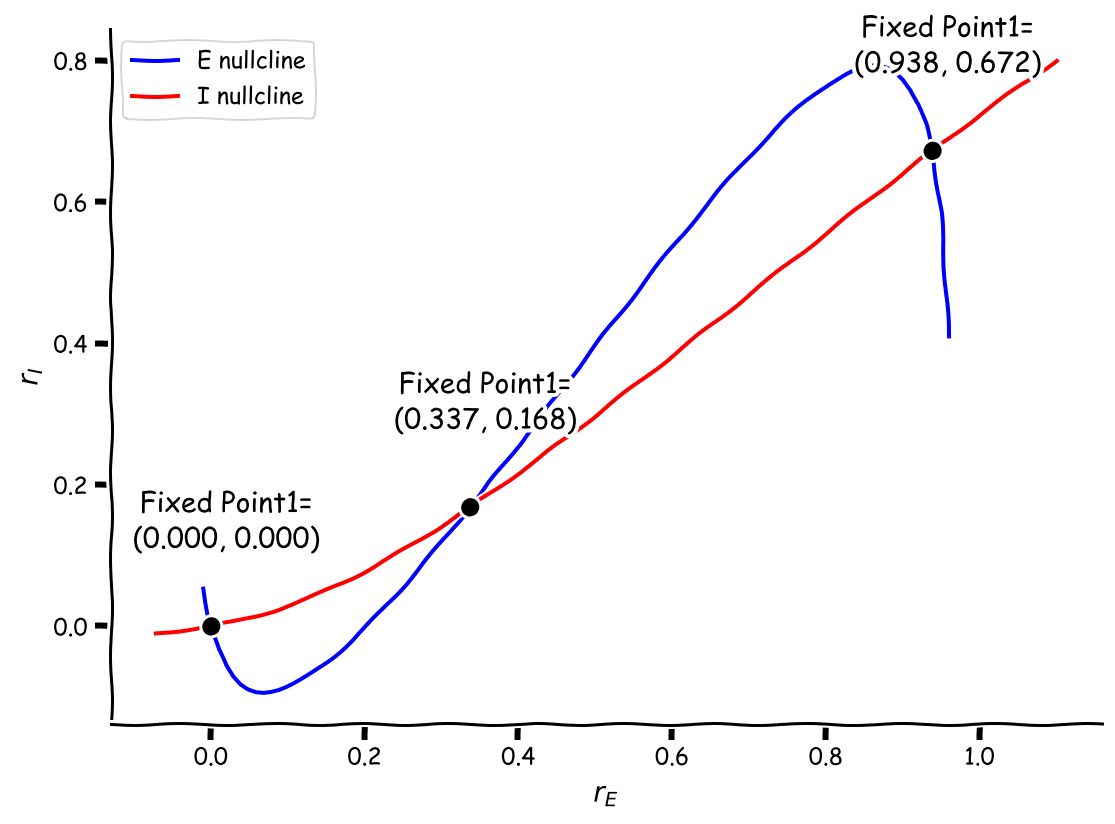

In [15]:
pars = default_pars()

with plt.xkcd():
  my_plot_nullcline(pars)

  # Find the first fixed point
  x_fp_1 = my_fp(pars, 0.1, 0.1)
  if check_fp(pars, x_fp_1):
    plot_fp(x_fp_1)

  # Find the second fixed point
  x_fp_2 = my_fp(pars, 0.3, 0.3)
  if check_fp(pars, x_fp_2):
    plot_fp(x_fp_2)

  # Find the third fixed point
  x_fp_3 = my_fp(pars, 0.8, 0.6)
  if check_fp(pars, x_fp_3):
    plot_fp(x_fp_3)

In [16]:
def get_eig_Jacobian(fp,
                     tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
                     tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """Compute eigenvalues of the Wilson-Cowan Jacobian matrix at fixed point."""
  # Initialization
  rE, rI = fp
  J = np.zeros((2, 2))

  # Compute the four elements of the Jacobian matrix
  J[0, 0] = (-1 + wEE * dF(wEE * rE - wEI * rI + I_ext_E,
                           a_E, theta_E)) / tau_E

  J[0, 1] = (-wEI * dF(wEE * rE - wEI * rI + I_ext_E,
                       a_E, theta_E)) / tau_E

  J[1, 0] = (wIE * dF(wIE * rE - wII * rI + I_ext_I,
                      a_I, theta_I)) / tau_I

  J[1, 1] = (-1 - wII * dF(wIE * rE - wII * rI + I_ext_I,
                           a_I, theta_I)) / tau_I

  # Compute and return the eigenvalues
  evals = np.linalg.eig(J)[0]
  return evals


# Compute eigenvalues of Jacobian
eig_1 = get_eig_Jacobian(x_fp_1, **pars)
eig_2 = get_eig_Jacobian(x_fp_2, **pars)
eig_3 = get_eig_Jacobian(x_fp_3, **pars)

print(eig_1, 'Stable point')
print(eig_2, 'Unstable point')
print(eig_3, 'Stable point')

[-0.62338386+0.13110957j -0.62338386-0.13110957j] Stable point
[ 1.05720798 -0.87266898] Unstable point
[-0.95956219 -1.42197413] Stable point


In [17]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_nullcline_diffwEE(wEE):
  """
    plot nullclines for different values of wEE
  """

  pars = default_pars(wEE=wEE)

  # plot the E, I nullclines
  Exc_null_rE = np.linspace(-0.01, .96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)

  Inh_null_rI = np.linspace(-.01, .8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.figure(figsize=(12, 5.5))
  plt.subplot(121)
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')

  plt.subplot(222)
  pars['rE_init'], pars['rI_init'] = 0.2, 0.2
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E/I activity\nfor different initial conditions',
            fontweight='bold')

  plt.subplot(224)
  pars['rE_init'], pars['rI_init'] = 0.4, 0.1
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population', clip_on=False)
  plt.plot(pars['range_t'], rI, 'r', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()


_ = widgets.interact(plot_nullcline_diffwEE, wEE=(6., 10., .01))

interactive(children=(FloatSlider(value=8.0, description='wEE', max=10.0, min=6.0, step=0.01), Output()), _dom…

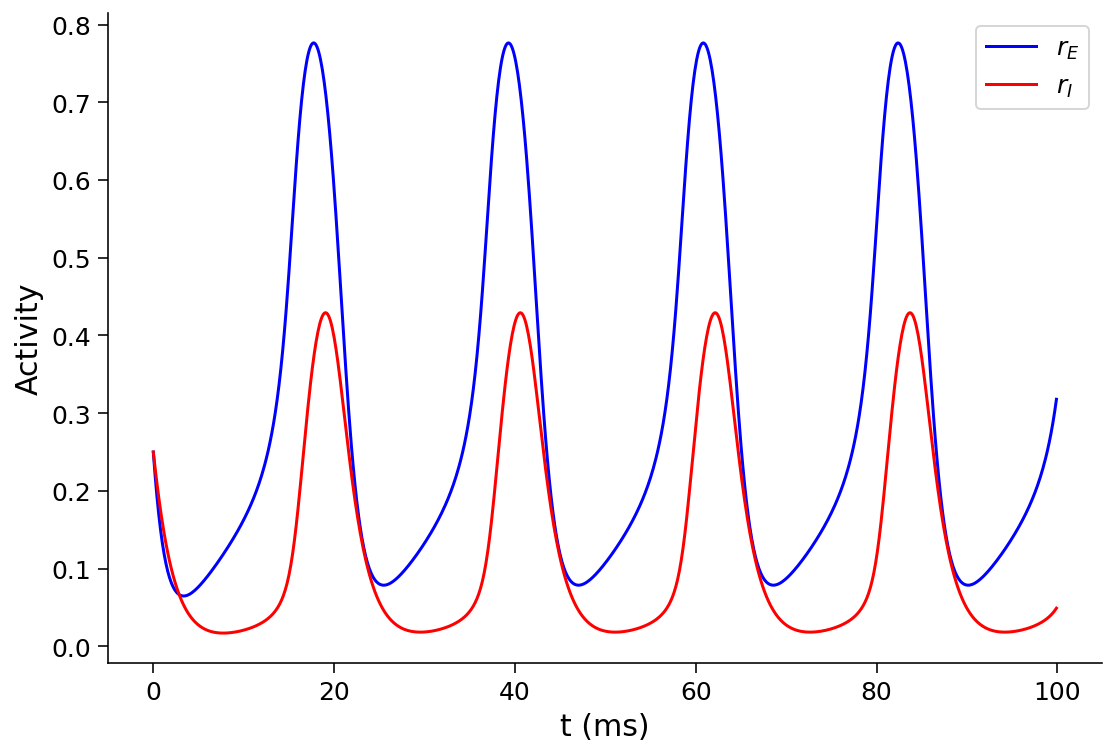

In [18]:
# @title

# @markdown Make sure you execute this cell to see the oscillations!

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['rE_init'], pars['rI_init'] = 0.25, 0.25

rE, rI = simulate_wc(**pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
plt.xlabel('t (ms)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

/var/folders/xk/gnb4n0td03qbprstn71hlyvc0000gn/T/ipykernel_2444/1483626268.py:91: RuntimeWarning: invalid value encountered in reciprocal
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta


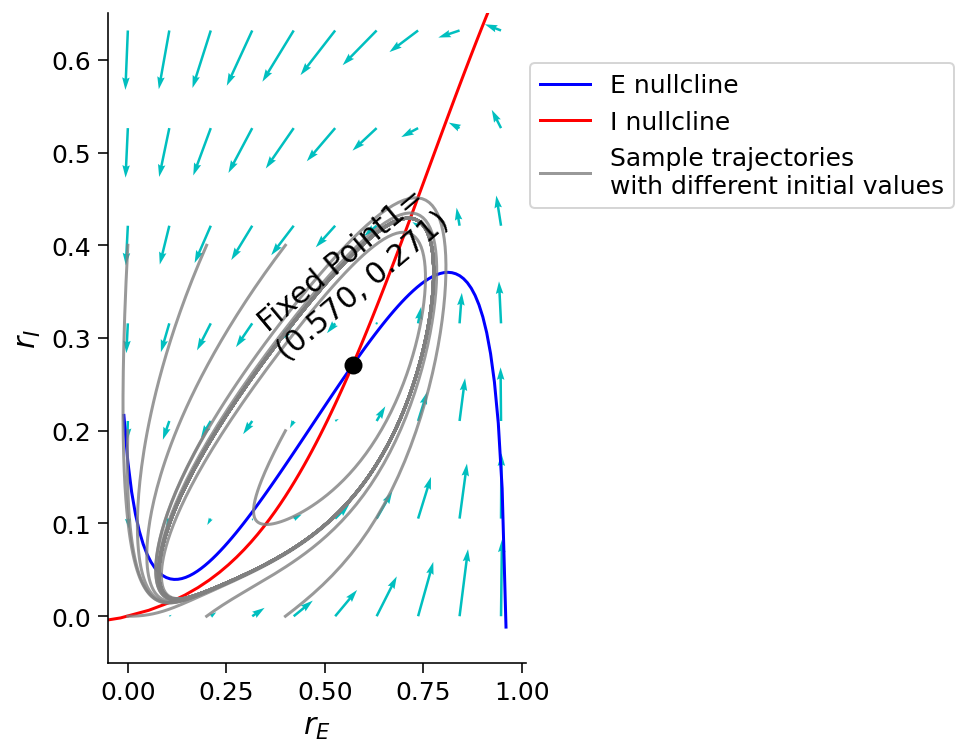

In [23]:
# @markdown Execute to visualize phase plane

pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8


plt.figure(figsize=(7, 5.5))
my_plot_nullcline(pars)

# Find the correct fixed point
x_fp_1 = my_fp(pars, 0.8, 0.8)
if check_fp(pars, x_fp_1):
  plot_fp(x_fp_1, position=(0, 0), rotation=40)

my_plot_trajectories(pars, 0.2, 3,
                      'Sample trajectories \nwith different initial values')

my_plot_vector(pars)


plt.legend(loc=[1.01, 0.7])
plt.xlim(-0.05, 1.01)
plt.ylim(-0.05, 0.65)
plt.show()